In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import mannwhitneyu

In [ ]:
# Replace 'otu_file' with the path to your TSV file
otu_file = 'otu_table_psn_v35.txt'
# wget http://downloads.hmpdacc.org/data/HMQCP/otu_table_psn_v35.txt.gz
# Read the TSV file while skipping the first line
otu_data = pd.read_csv(otu_file, sep='\t', skiprows=1)
# otu_data = pd.read_csv("path_to_your_output_file.csv")
otu_data.columns.values[0] = 'otu_id'

# Define a function to parse the taxonomic data
def parse_tax_data(otu_data, class_cols, class_regex, class_key, class_sep):
    # Extract class information based on class_cols and class_sep
    tax_data = otu_data[class_cols].str.split(class_sep, expand=True)
    
    # Create a DataFrame for taxonomic classification
    tax_data.columns = [f'{class_key["hmp_rank"]}_{i}' for i in range(tax_data.shape[1])]
    tax_data[class_key["hmp_tax"]] = tax_data.apply(lambda row: class_sep.join(row.dropna()), axis=1)
    
    # Merge taxonomic data back with the original OTU data
    otu_data = otu_data.drop(columns=[class_cols])
    otu_data = pd.concat([otu_data, tax_data], axis=1)
    
    return otu_data

# # Apply the function to parse taxonomic data
hmp_data = parse_tax_data(otu_data, "Consensus Lineage", r"([a-z]{0,1})_{0,2}(.*)$", {"hmp_rank": "taxon_rank", "hmp_tax": "taxon_name"}, ";")

# # Remove the regex match table (not needed in this case)
otu_data = hmp_data.drop(columns=[col for col in hmp_data.columns if col.startswith('taxon_rank_')])

# # Rename the abundance matrix to something more understandable
otu_data.columns = ['otu_count' if col == 'otu_id' else col for col in otu_data.columns]
# Select the top 1000 rows
# top_1000_hmp_data = hmp_data.head(5)


# Extract the suffix of 'g__' in the 'taxon_name' column
otu_data['genus'] = otu_data['taxon_name'].str.extract(r'g__([^;]*)')
otu_data = otu_data[otu_data['genus'].notna() & (otu_data['genus'] != '')]
# # Delete the 'taxon_name' column
otu_data = otu_data.drop(columns=['taxon_name'])
# # Group by 'genus' and accumulate the OTU counts
# if 'genus' in otu_data.columns:
#     otu_data = otu_data.groupby('genus').sum().reset_index()
# else:
#     otu_data = otu_data  # If there is no 'genus' column, use the original data

# # Print the filtered DataFrame
# print(otu_data.head(5))
# otu_data = otu_data.drop(columns=['otu_count'])
num_rows, num_columns = otu_data.shape
# print(f'The DataFrame has {num_rows} rows and {num_columns} columns.')
# Rotate the DataFrame 90 degrees clockwise
otu_data = otu_data.transpose()

# Make the first row the header
otu_data.columns = otu_data.iloc[0]
otu_data = otu_data[1:]
otu_data.to_csv("genus_rotated.csv", index=False)
# Define the path for the output CSV file
# csv_file = 'path_to_your_output_file.csv'

# # Convert the DataFrame to a CSV file
# top_1000_hmp_data.to_csv(csv_file, index=False)


In [9]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Load the OTU table file
otu_table = pd.read_csv('genus_rotated.csv', header=0, index_col=0)
# print(otu_table.head(2))
# Create a dictionary to map genus names to unique indices
# genus_names = otu_table.columns.tolist()
# genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}

# # print(genus_to_idx)
# # Define a dataset class
# class OTUDataset(Dataset):
#     def __init__(self, data, genus_to_idx):
#         self.data = data
#         self.genus_to_idx = genus_to_idx
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         counts = self.data.iloc[idx].tolist()
#         input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
#         # print(input_ids)
#         return {
#             'input_ids': torch.tensor(input_ids, dtype=torch.long),
#             'labels': torch.tensor(counts, dtype=torch.float)
#         }

# # Create a dataset and dataloader
# dataset = OTUDataset(otu_table, genus_to_idx)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
# dataset
# Normalize the OTU table using Min-Max scaling
# min_vals = otu_table.min()
# max_vals = otu_table.max()
# otu_table_normalized = (otu_table - min_vals) / (max_vals - min_vals)
# print(min_vals,max_vals)
# Convert counts to proportions
otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
# Create a dictionary to map genus names to unique indices
genus_names = otu_table_normalized.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}

# Define a dataset class
class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx):
        self.data = data
        self.genus_to_idx = genus_to_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float)
        }

# Create a dataset and dataloader
dataset = OTUDataset(otu_table_normalized, genus_to_idx)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

Epoch 1/32, Loss: 0.0259
Epoch 2/32, Loss: 0.0089
Epoch 3/32, Loss: 0.0074
Epoch 4/32, Loss: 0.0064
Epoch 5/32, Loss: 0.0055
Epoch 6/32, Loss: 0.0047
Epoch 7/32, Loss: 0.0036
Epoch 8/32, Loss: 0.0025
Epoch 9/32, Loss: 0.0016
Epoch 10/32, Loss: 0.0011
Epoch 11/32, Loss: 0.0009
Epoch 12/32, Loss: 0.0009
Epoch 13/32, Loss: 0.0008
Epoch 14/32, Loss: 0.0008
Epoch 15/32, Loss: 0.0008
Epoch 16/32, Loss: 0.0008
Epoch 17/32, Loss: 0.0008
Epoch 18/32, Loss: 0.0007
Epoch 19/32, Loss: 0.0007
Epoch 20/32, Loss: 0.0007
Epoch 21/32, Loss: 0.0007
Epoch 22/32, Loss: 0.0007
Epoch 23/32, Loss: 0.0007
Epoch 24/32, Loss: 0.0007
Epoch 25/32, Loss: 0.0007
Epoch 26/32, Loss: 0.0007
Epoch 27/32, Loss: 0.0007
Epoch 28/32, Loss: 0.0007
Epoch 29/32, Loss: 0.0007
Epoch 30/32, Loss: 0.0007
Epoch 31/32, Loss: 0.0007
Epoch 32/32, Loss: 0.0007
Training Time: 511.19 seconds


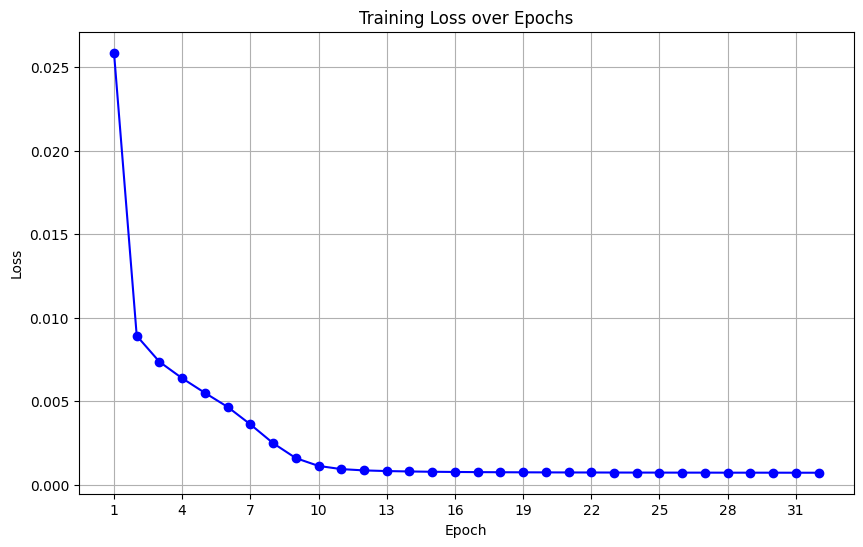

In [11]:
import time
import matplotlib.pyplot as plt
# Define the transformer model
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, labels=None):
        src = self.embedding(src) + self.pos_encoder(torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1))
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        logits = self.regressor(output)
        
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(logits, labels)
        
        return loss, logits
# Define the model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx)
d_model = 256
nhead = 4
num_encoder_layers = 4
dim_feedforward = 512#512
max_seq_length = len(genus_to_idx)
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=1e-5)
num_epochs = 32
start_time = time.time()
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')

# Save the model
torch.save(model.state_dict(), 'simple_transformer_model.pth')
# Plotting the loss function figure
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))  # Adjust x-ticks for better readability
plt.show()

In [13]:
# Load the OTU table file
otu_table = pd.read_csv('genus_rotated.csv', header=0, index_col=0)
# print(otu_table.head(2))
# Create a dictionary to map genus names to unique indices
genus_names = otu_table.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}

# print(genus_to_idx)
# Define a dataset class
class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx):
        self.data = data
        self.genus_to_idx = genus_to_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
        # print(input_ids)
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float)
        }

# Create a dataset and dataloader
dataset = OTUDataset(otu_table, genus_to_idx)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
dataset


Epoch 1/32, Loss: 48141.0911
Epoch 2/32, Loss: 48091.3728
Epoch 3/32, Loss: 48045.3445
Epoch 4/32, Loss: 47996.9428
Epoch 5/32, Loss: 47946.5930
Epoch 6/32, Loss: 47894.8975
Epoch 7/32, Loss: 47842.0042
Epoch 8/32, Loss: 47788.6388
Epoch 9/32, Loss: 47734.1518
Epoch 10/32, Loss: 47678.4005
Epoch 11/32, Loss: 47622.5627
Epoch 12/32, Loss: 47566.0051
Epoch 13/32, Loss: 47509.0703
Epoch 14/32, Loss: 47451.3208
Epoch 15/32, Loss: 47393.2521
Epoch 16/32, Loss: 47335.0671
Epoch 17/32, Loss: 47275.9287
Epoch 18/32, Loss: 47216.7980
Epoch 19/32, Loss: 47156.9723
Epoch 20/32, Loss: 47096.9965
Epoch 21/32, Loss: 47037.1799
Epoch 22/32, Loss: 46977.1701
Epoch 23/32, Loss: 46917.1316
Epoch 24/32, Loss: 46856.9515
Epoch 25/32, Loss: 46796.2478
Epoch 26/32, Loss: 46735.5708
Epoch 27/32, Loss: 46675.4900
Epoch 28/32, Loss: 46615.5629
Epoch 29/32, Loss: 46555.5568
Epoch 30/32, Loss: 46495.5382
Epoch 31/32, Loss: 46435.8355
Epoch 32/32, Loss: 46376.6384
Training Time: 510.81 seconds


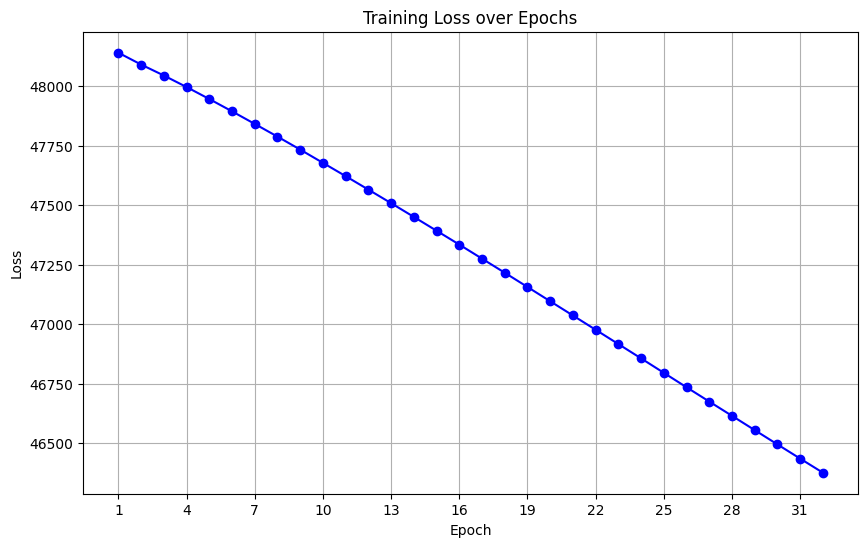

In [14]:
import time
import matplotlib.pyplot as plt
# Define the transformer model
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, labels=None):
        src = self.embedding(src) + self.pos_encoder(torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1))
        output = self.transformer_encoder(src)
        output = output[:, 0, :]  # Use the first token representation for regression
        logits = self.regressor(output)
        
        loss = None
        if labels is not None:
            loss = nn.MSELoss()(logits, labels)
        
        return loss, logits
# Define the model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(genus_to_idx)
d_model = 256
nhead = 4
num_encoder_layers = 4
dim_feedforward = 512#512
max_seq_length = len(genus_to_idx)
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length).to(device)

# Training loop
optimizer = Adam(model.parameters(), lr=1e-5)
num_epochs = 32
start_time = time.time()
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time:.2f} seconds')

# Save the model
torch.save(model.state_dict(), 'simple_transformer_model.pth')
# Plotting the loss function figure
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))  # Adjust x-ticks for better readability
plt.show()